<a href="https://colab.research.google.com/github/nidhi7330/nidhi7330/blob/main/Tour_Content_based_Recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [272]:
#importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix


In [273]:
#reding the dataset
tour_desc = pd.read_csv('/content/tour_final.csv')#,encoding = 'utf-8')


In [274]:
#Give the number of rows and columns
tour_desc.shape

(199, 11)

In [275]:
#To get the overview of the dataset
tour_desc.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199 entries, 0 to 198
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Count       199 non-null    int64  
 1   Title       199 non-null    object 
 2   Vote_count  199 non-null    int64  
 3   Rating      199 non-null    float64
 4   Category    199 non-null    object 
 5   Days        199 non-null    object 
 6   Location    199 non-null    object 
 7   Keywords    199 non-null    object 
 8   Country     199 non-null    object 
 9   Price       199 non-null    int64  
 10  Image_url   199 non-null    object 
dtypes: float64(1), int64(3), object(7)
memory usage: 17.2+ KB


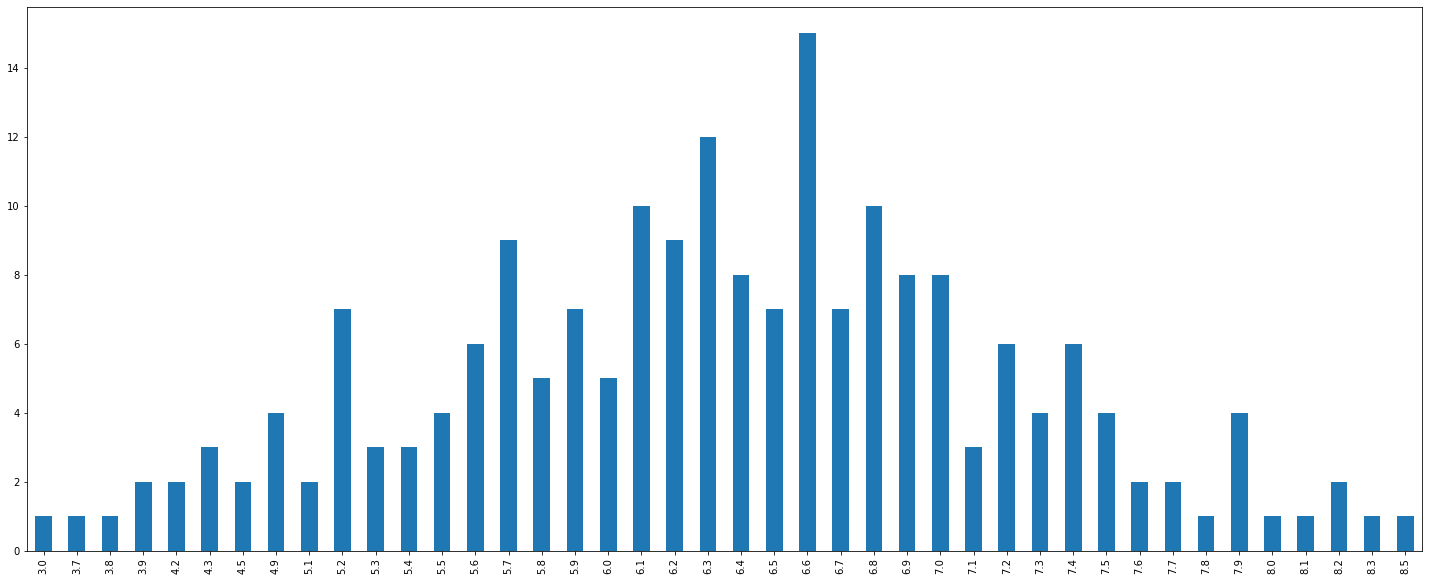

In [276]:
#Generating graph on the basis of Price distribution
tour_desc['Rating'].value_counts(dropna=False).sort_index().plot(kind= 'bar', figsize=(25,10))

In [277]:
#Calculating the mean of Rating
C = tour_desc['Rating'].mean()

In [278]:
#Calculating Quantile range on the basis of Vote_count
m =  tour_desc['Vote_count'].quantile(0.10)

In [279]:
## Filtering all the tour that have vote_count more than 'm'
quali =  tour_desc.copy().loc[ tour_desc['Vote_count'] >= m]
quali.shape

(180, 11)

In [280]:
# Calculating the weighted rating of each tour package
def weighted_rate(v, R, m=m, C=C):
  ans = (v/(v+m) * R)+(m/(v+m) * C)
  return ans


In [281]:
quali['Score'] = quali.apply(lambda row : weighted_rate(row['Vote_count'], row['Rating']), axis = 1)


In [282]:
quali = quali.sort_values('Score', ascending=False)


In [283]:
(quali
 .query('Location == "Uttarpradesh"')
 .sort_values('Score', ascending=False).head(10))

,Count,Title,Vote_count,Rating,Category,Days,Location,Keywords,Country,Price,Image_url,Score
94,201639,ShershahSuri 's Tomb,567,8.1,Pilgrimage,8N 9D,Uttarpradesh,built in memory of Emperor Sher Shah Suri,India,15000,https://1.bp.blogspot.com/-A2MRcbMrHZU/WScWZE7...,7.973823
106,5732,Kohinoor Palace,654,7.9,Heritage,6N 7D,Uttarpradesh,"royal residence, or the home of a head of state",India,10000,https://encrypted-tbn0.gstatic.com/images?q=tb...,7.801911
107,5266,Group of Temples,134,8.2,Heritage,7N 8D,Uttarpradesh,reserved for religious or spiritual rituals,India,14000,https://encrypted-tbn0.gstatic.com/images?q=tb...,7.740860
79,227668,Jhansi Fort,245,7.8,Fort,9N 10D,Uttarpradesh,Jhansi ka Kila is a fortress,India,22000,https://icdn.isrgrajan.com/in/2017/05/Jhansi-F...,7.577542
0,5419608,Taj Mahal,167,7.9,Architecture,2N 3D,Uttarpradesh,immense mausoleum of white marble,India,8500,https://cdn.britannica.com/86/170586-050-AB7FE...,7.574439
102,22309,Observatory Man Singh,123,7.6,Pilgrimage,4N 5D,Uttarpradesh,famous as a masonry observatory,India,6500,https://i2.wp.com/varanasivideos.com/wp-conten...,7.265856
1,1799953,Agra Fort,158,7.2,Fort,3N 4D,Uttarpradesh,historical fort in Agra,India,10000,https://www.fabhotels.com/blog/wp-content/uplo...,7.009613
117,63206,Mehtab Bagh,789,7.0,Pilgrimage,4N 5D,Uttarpradesh,perfectly aligned with the Taj Mahal,India,5000,http://res.cloudinary.com/dwzmsvp7f/image/uplo...,6.964342
98,52559,Laxman Temple Sirpur,567,6.8,Heritage,5N 6D,Uttarpradesh,7th-century brick temple,India,6700,https://new-img.patrika.com/upload/2018/04/30/...,6.765463
96,185316,Remains of Patliputra Kumrahar,678,6.6,Wildlife,9N 10D,Uttarpradesh,ancient city of Pataliputra,India,20000,https://greatindianjourney.files.wordpress.com...,6.582708


In [284]:
conbas_df = quali[['Title','Category','Days','Location','Keywords','Image_url']]


In [285]:
#converting the names and keyword instances into lowercase and strip all the spaces between them #comparing the code with keywords
conbas_df['Category'] = conbas_df['Category'].str.replace(' ','').str.lower().str.replace('-','')
conbas_df['Location'] = conbas_df['Location'].str.replace(' ','').str.lower().str.replace('-',' ')
conbas_df['Days'] = conbas_df['Days'].str.replace(' ','').str.lower().str.replace('-',' ')
#conbas_df['Image_url'] = conbas_df['Image_url'].str.replace(' ','').str.lower().str.replace('-','')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [286]:
 conbas_df['Keywords'] = conbas_df['Keywords'].replace(np.nan, 'Not Available')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [287]:
conbas_df['soup'] = conbas_df['Keywords'] + ' ' + conbas_df['Category'] + ' ' + conbas_df['Days'] + ' ' + conbas_df['Location'] 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [288]:
conbas_df.columns


Index(['Title', 'Category', 'Days', 'Location', 'Keywords', 'Image_url',
       'soup'],
      dtype='object')

In [289]:
conbas_df = conbas_df.drop(columns=['Category','Days','Location','Keywords','Image_url'])


In [290]:
conbas_df.head()


,Title,soup
46,KotlaFeroz Shah,built by Sultan Feroz Shah Tughlaq pilgrimage ...
49,Sultanghari 's Tomb,implanted in a Ghari (cave) heritage 7n8d delhi
94,ShershahSuri 's Tomb,built in memory of Emperor Sher Shah Suri pilg...
5,Krabi,"province characterized by craggy, sheer limest..."
57,Ranghar Pavillion Jaisagar,constructed to watch cultural programs and gam...


In [291]:
conbas_df.shape


(180, 2)

In [292]:
q = pd.merge(quali,conbas_df, left_on=['Title'], right_on=['Title'], how='left')


In [293]:
conbas_df.head()

,Title,soup
46,KotlaFeroz Shah,built by Sultan Feroz Shah Tughlaq pilgrimage ...
49,Sultanghari 's Tomb,implanted in a Ghari (cave) heritage 7n8d delhi
94,ShershahSuri 's Tomb,built in memory of Emperor Sher Shah Suri pilg...
5,Krabi,"province characterized by craggy, sheer limest..."
57,Ranghar Pavillion Jaisagar,constructed to watch cultural programs and gam...


In [294]:
q[q['Category'].str.contains('Heritage', na=False)]

,Count,Title,Vote_count,Rating,Category,Days,Location,Keywords,Country,Price,Image_url,Score,soup
1,1408,Sultanghari 's Tomb,348,8.2,Heritage,7N 8D,Delhi,implanted in a Ghari (cave),India,10900,https://s3.us-east-1.amazonaws.com/media.archn...,7.992154,implanted in a Ghari (cave) heritage 7n8d delhi
3,215845,Krabi,890,7.9,Heritage,5N 6D,southern Thailand,"province characterized by craggy, sheer limest...",Thailand,10000,https://cdn.thecrazytourist.com/wp-content/upl...,7.826723,"province characterized by craggy, sheer limest..."
4,106925,Ranghar Pavillion Jaisagar,773,7.9,Heritage,5N 6D,Assam,constructed to watch cultural programs and games,India,5000,https://upload.wikimedia.org/wikipedia/commons...,7.816216,constructed to watch cultural programs and gam...
5,5732,Kohinoor Palace,654,7.9,Heritage,6N 7D,Uttarpradesh,"royal residence, or the home of a head of state",India,10000,https://encrypted-tbn0.gstatic.com/images?q=tb...,7.801911,"royal residence, or the home of a head of stat..."
6,5266,Group of Temples,134,8.2,Heritage,7N 8D,Uttarpradesh,reserved for religious or spiritual rituals,India,14000,https://encrypted-tbn0.gstatic.com/images?q=tb...,7.740860,reserved for religious or spiritual rituals he...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
174,25026,Warangal,45,3.0,Heritage,7N 8D,Telangana,ancient capital of Kakatiya dynasty.,India,13000,https://www.incredibleindia.org/content/dam/in...,4.617411,ancient capital of Kakatiya dynasty. heritage ...
175,22309,Mariam's Tomb Sikandara,245,4.3,Heritage,3N 4D,Uttarpradesh,Queen consort of the Mughal Emperor Akbar,India,4500,https://www.trawell.in/admin/images/upload/763...,4.600112,Queen consort of the Mughal Emperor Akbar heri...
176,1551835,Charminar,908,4.5,Heritage,7N 8D,Hyderabad,landmark has become known as a symbol of Hyder...,India,14000,https://curlytales.com/wp-content/uploads/2020...,4.581842,landmark has become known as a symbol of Hyder...
178,24976,Rock cut-Jain Temple,876,4.3,Heritage,5N 6D,Tamilnadu,carved from a large rock,India,6000,https://pragyata.com/wp-content/uploads/2019/1...,4.394050,carved from a large rock heritage 5n6d tamilnadu


In [295]:
q.shape


(182, 13)

In [296]:
q[q.duplicated(['Title'])]

,Count,Title,Vote_count,Rating,Category,Days,Location,Keywords,Country,Price,Image_url,Score,soup
16,296066,Group of Monuments,589,7.4,Park,8N 9D,Karnataka,famous for their harmonious blend of architect...,India,15000,https://4.bp.blogspot.com/-kAl3oDftWFM/XFR2Yt6...,7.325842,collection of 7th- and 8th-century religious m...
114,960963,Group of Monuments,590,6.1,Heritage,6N 7D,Tamilnadu,collection of 7th- and 8th-century religious m...,India,8500,https://i.pinimg.com/originals/df/76/67/df7667...,6.114269,famous for their harmonious blend of architect...
115,960963,Group of Monuments,590,6.1,Heritage,6N 7D,Tamilnadu,collection of 7th- and 8th-century religious m...,India,8500,https://i.pinimg.com/originals/df/76/67/df7667...,6.114269,collection of 7th- and 8th-century religious m...


In [250]:
#q = q.drop(columns=['Count','Vote_count','Rating','Keywords','Price'])

In [297]:
q.to_csv('/content/travel.csv')


In [298]:
q.head()

,Count,Title,Vote_count,Rating,Category,Days,Location,Keywords,Country,Price,Image_url,Score,soup
0,82419,KotlaFeroz Shah,654,8.3,Pilgrimage,6N 7D,Delhi,built by Sultan Feroz Shah Tughlaq,India,6500,https://static.toiimg.com/photo/68271442.cms,8.177234,built by Sultan Feroz Shah Tughlaq pilgrimage ...
1,1408,Sultanghari 's Tomb,348,8.2,Heritage,7N 8D,Delhi,implanted in a Ghari (cave),India,10900,https://s3.us-east-1.amazonaws.com/media.archn...,7.992154,implanted in a Ghari (cave) heritage 7n8d delhi
2,201639,ShershahSuri 's Tomb,567,8.1,Pilgrimage,8N 9D,Uttarpradesh,built in memory of Emperor Sher Shah Suri,India,15000,https://1.bp.blogspot.com/-A2MRcbMrHZU/WScWZE7...,7.973823,built in memory of Emperor Sher Shah Suri pilg...
3,215845,Krabi,890,7.9,Heritage,5N 6D,southern Thailand,"province characterized by craggy, sheer limest...",Thailand,10000,https://cdn.thecrazytourist.com/wp-content/upl...,7.826723,"province characterized by craggy, sheer limest..."
4,106925,Ranghar Pavillion Jaisagar,773,7.9,Heritage,5N 6D,Assam,constructed to watch cultural programs and games,India,5000,https://upload.wikimedia.org/wikipedia/commons...,7.816216,constructed to watch cultural programs and gam...


In [299]:
q['soup'].head()


0    built by Sultan Feroz Shah Tughlaq pilgrimage ...
1      implanted in a Ghari (cave) heritage 7n8d delhi
2    built in memory of Emperor Sher Shah Suri pilg...
3    province characterized by craggy, sheer limest...
4    constructed to watch cultural programs and gam...
Name: soup, dtype: object

In [300]:
# removing the stop words
from sklearn.feature_extraction.text import CountVectorizer
tour_tfidf = CountVectorizer(stop_words='english')
# computing TF-IDF matrix required for calculating cosine similarity
tour_matrix = tour_tfidf.fit_transform(q['soup'].values.astype('U'))

In [301]:
tour_matrix.shape


(182, 598)

In [302]:
# Compute the Cosine Similarity matrix based on the count_matrix
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim = cosine_similarity(tour_matrix, tour_matrix)

In [303]:
# Reset index of your main DataFrame and construct reverse mapping as before
q = q.reset_index()
indices = pd.Series(q.index, index=q['Title'])
# indices1 = pd.Series(q.index, index=q['Rating'])
# indices = pd.Series(q.index, index=q['Price'])



In [304]:
def get_recommendations(Title, cosine_sim = cosine_sim):
    idx = indices[Title]
    idx -=1  # Get the index of the Destination that matches the title
    sim_scores = list(enumerate(cosine_sim[idx]))   # Get the pairwsie similarity scores of all Destinations with that Destination
    #print(sim_scores)
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)  # Sort the Destinations based on the similarity scores
    #print(sim_scores)
    sim_scores = sim_scores[1:11]  # Get the scores of the 15 most similar Destinations
    #print(sim_scores)
    Tour_indices = [i[0] for i in sim_scores]  # Get the Destination indices
    Tour = q.iloc[Tour_indices][['Title', 'Rating','Price','Image_url']]

    return tour_desc['Title'].iloc[Tour_indices]

In [305]:
get_recommendations("Taj Mahal")

28                        Ratnagiri Monument
66                               Chandragiri
155    Chunnambar beach and Backwater Resort
157                                Khajuraho
17                                    Phuket
41                                  Red Fort
64                                 Charminar
160                     Backwaters of Kerala
6                                  Kathmandu
8                                       Bali
Name: Title, dtype: object

In [306]:
get_recommendations("Krabi")

160                     Backwaters of Kerala
149                           Vythiri Resort
0                                  Taj Mahal
155    Chunnambar beach and Backwater Resort
17                                    Phuket
173                           Sam Sand Dunes
29                          Raja Rani Temple
67                            Nagarjunakonda
74                         Hazardwari Palace
113                           Buddhist Caves
Name: Title, dtype: object

In [307]:
get_recommendations("Nature Zone Resort")

51                  Caves, Badami
47                    Tughluqabad
104                        Masrur
170                          Fiji
1                       Agra Fort
6                       Kathmandu
31           Sheikh Chilli's Tomb
57     Ranghar Pavillion Jaisagar
89           Aga Khan Palace Pune
174               Nameri Eco Camp
Name: Title, dtype: object

In [309]:
get_recommendations("Royal Palaces")

142                              Gondal
128                      Keshava Temple
79                          Jhansi Fort
147                           Porbandar
152               Hornbill River Resort
0                             Taj Mahal
12                                Hanoi
37                Fort on Rock Dindigul
55     Temple & Sculpture Shed Lakkundi
122                     Daulatabad Fort
Name: Title, dtype: object

In [310]:
get_recommendations("Buddhist Caves")

104                             Masrur
170                               Fiji
1                            Agra Fort
135              Ahmedpur Mandvi Beach
166                     Archaeological
6                            Kathmandu
24     The Palace Situated at Burhapur
30                 Lalitagiri Monument
57          Ranghar Pavillion Jaisagar
89                Aga Khan Palace Pune
Name: Title, dtype: object